# Debug Test Script EnergyDiff

In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import torch
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import pandas as pd

from src.opensynth.data_modules.lcl_data_module import LCLDataModule, LCLData
from src.opensynth.models.energydiff import diffusion, model

/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LCLDataModuleWithValidation(LCLDataModule):
    def __init__(self, data_path, stats_path, batch_size=32, n_samples=1000, outlier_path=None, n_val_samples=200):
        super().__init__(data_path, stats_path, batch_size, n_samples, outlier_path=outlier_path)
        self.n_val_samples = n_val_samples

    def setup(self, stage=None):
        super().setup(stage)
        self.val_dataset = LCLData(
            data_path=self.data_path,
            stats_path=self.stats_path,
            n_samples=self.n_val_samples,
            outlier_path=self.outlier_path,
        )
        
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            self.batch_size,
            drop_last=True,
            shuffle=False,
        )
        

In [3]:
# prep data
data_path = Path("data/processed/historical/train/lcl_data.csv")
stats_path = Path("data/processed/historical/train/mean_std.csv")
outlier_path = Path("data/processed/historical/train/outliers.csv")

dm = LCLDataModuleWithValidation(
    data_path=data_path,
    stats_path=stats_path,
    batch_size=200,
    n_samples=2000,
)
dm.setup()

In [4]:
# fake data
def get_noisy_sin(n_samples):
    x = np.linspace(0, 3/2 * np.pi, 48)
    samples = []
    for _ in range(n_samples):
        phase = np.random.uniform(0, 2 * np.pi)
        y = np.sin(x + phase) + np.random.normal(0, 0.01, x.shape)
        samples.append(y)
    return {
        'kwh': torch.from_numpy(np.array(samples)).float(), 
        'features': torch.from_numpy(x).float()
    }
    
class SinDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples=1000):
        self.data = get_noisy_sin(n_samples)
    
    def __len__(self):
        return len(self.data['kwh'])
    
    def __getitem__(self, idx):
        return {
            'kwh': self.data['kwh'][idx],
            'features': self.data['features']
        }

class SinDataModule(pl.LightningDataModule):
    def __init__(self, n_samples=1000, batch_size=32, n_val_samples=0):
        super().__init__()
        self.n_samples = n_samples
        self.n_val_samples = n_val_samples
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SinDataset(self.n_samples)
        self.val_dataset = SinDataset(self.n_val_samples)

    def train_dataloader(self):
        dataset = self.train_dataset
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        dataset = self.val_dataset
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size)


In [5]:
# dm = SinDataModule(n_samples=1000, batch_size=200, n_val_samples=600)
# dm.setup()

In [11]:
# prep model
denoise_model = model.DenoisingTransformer(
    dim_base=128,
    dim_in=1,
    num_attn_head=4,
    num_decoder_layer=12,
    dim_feedforward=512,
    dropout=0.1,
    learn_variance=False,
)
df_model = diffusion.PLDiffusion1D(
    base_model=denoise_model,
    num_timestep=500,
    model_mean_type=diffusion.ModelMeanType.V,
    model_variance_type=diffusion.ModelVarianceType.FIXED_SMALL,
    loss_type=diffusion.LossType.MSE,
    beta_schedule_type=diffusion.BetaScheduleType.COSINE,
    lr=1e-3,
    ema_update_every=1,
    ema_decay=0.99,
)
trainer = pl.Trainer(
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    max_epochs=500,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
PLDiffusion1D 

In [16]:
# [optional] load
model = df_model.setup('train')
df_model.load_state_dict(torch.load('lightning_logs/version_35/checkpoints/epoch=499-step=5000.ckpt')['state_dict'])

/var/folders/1l/4hsqmyts089_gc67gmnw8__80000gn/T/ipykernel_74897/4095093029.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  df_model.load_state_dict(torch.load('lightnin

<All keys matched successfully>

In [5]:
# training
trainer.fit(df_model, dm)


  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | diffusion_model | GaussianDiffusion1D | 3.7 M  | train
1 | ema             | EMA                 | 7.4 M  | train
----------------------------------------------------------------
3.7 M     Trainable params
3.7 M     Non-trainable params
7.4 M     Total params
29.598    Total estimated model params size (MB)
619       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:368: You have overridden `on_before_batch_transfer` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nanlin/miniforge3/envs/opensynth-dev/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s, v_num=35, train_loss_step=0.394, train_loss_epoch=0.439]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s, v_num=35, train_loss_step=0.394, train_loss_epoch=0.439]


In [6]:
log_dir = trainer.logger.log_dir
metrics = pd.read_csv(f"{log_dir}/metrics.csv")
epoch_train_loss = metrics['train_loss_epoch'].dropna().values
epoch_val_loss = metrics['val_loss'].dropna().values

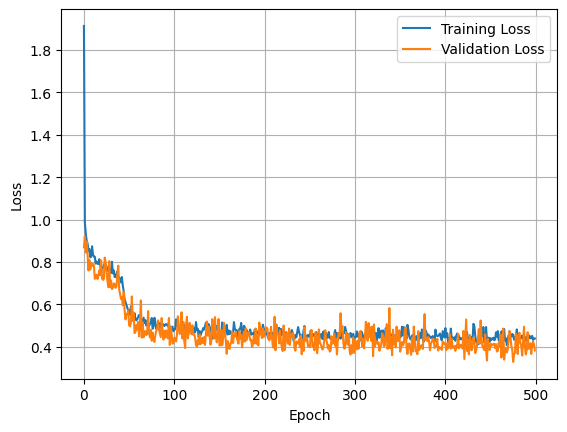

In [7]:
plt.plot(epoch_train_loss, label='Training Loss')
plt.plot(epoch_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# sample
ema_df_model = df_model.ema.ema_model # GaussianDiffusion1D
ans_samples = ema_df_model.ancestral_sample(50, 50, 48, 1)
dpm_samples = ema_df_model.dpm_solver_sample(50, 50, 100, (48, 1))
true_samples = dm.dataset[0:50]['kwh']

sampling batch 1/1, batch size 50. 


Sampling Loop Timestep: 100%|██████████| 500/500 [00:49<00:00, 10.05it/s]


sampling batch 1/1, batch size 50. 


multistep_dpm_solver_update: 100%|██████████| 498/498 [00:52<00:00,  9.49it/s]


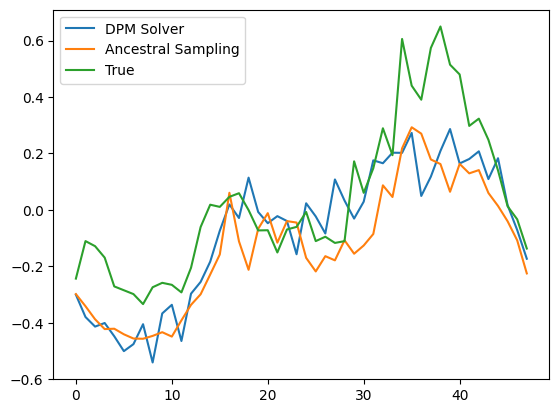

In [18]:
plt.plot(dpm_samples.mean(dim=0).cpu().numpy(), label='DPM Solver')
plt.plot(ans_samples.mean(dim=0).cpu().numpy(), label='Ancestral Sampling')
plt.plot(true_samples.mean(dim=0).cpu().numpy(), label='True')
plt.legend()
plt.show()

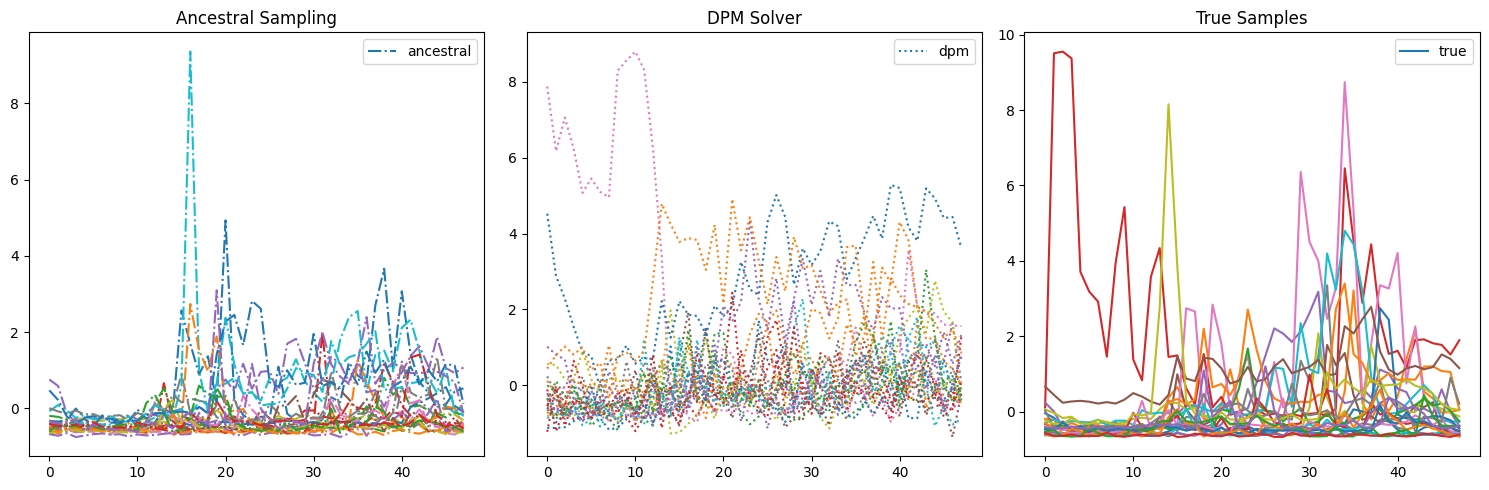

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for idx in range(min(ans_samples.shape[0], 25)):
    axs[0].plot(ans_samples[idx].detach().cpu().numpy(), linestyle='-.', label="ancestral" if idx == 0 else None)
axs[0].set_title('Ancestral Sampling')
axs[0].legend()

for idx in range(min(dpm_samples.shape[0], 25)):
    axs[1].plot(dpm_samples[idx].detach().cpu().numpy(), linestyle=':', label="dpm" if idx == 0 else None)
axs[1].set_title('DPM Solver')
axs[1].legend()

for idx in range(min(true_samples.shape[0], 25)):
    axs[2].plot(true_samples[idx].detach().cpu().numpy(), label="true" if idx == 0 else None)
axs[2].set_title('True Samples')
axs[2].legend()

plt.tight_layout()
plt.show()
pass